In [17]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB #binary ise Bernolli veya Gauss kullanılır
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob , Word
from nltk.stem.snowball import SnowballStemmer

from langdetect import detect
%matplotlib inline

from nltk import word_tokenize

from wordcloud import WordCloud
from wordcloud import WordCloud , STOPWORDS

In [18]:
import warnings


warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [20]:
import os
import pandas as pd

dataset = "Electronics_5.json"

if os.path.isfile(dataset):
    df_mane = pd.read_json("Electronics_5.json", lines=True)
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df_mane = pd.read_json(url, compression='gzip', lines=True)

KeyboardInterrupt: 

In [21]:
df_mane = pd.read_csv("amazon.csv")

In [22]:
df_mane.head()

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [23]:
df_mane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1689188 non-null  int64 
 1   reviewerID      1689188 non-null  object
 2   asin            1689188 non-null  object
 3   reviewerName    1664309 non-null  object
 4   helpful         1689188 non-null  object
 5   reviewText      1688117 non-null  object
 6   overall         1689188 non-null  int64 
 7   summary         1689173 non-null  object
 8   unixReviewTime  1689188 non-null  int64 
 9   reviewTime      1689188 non-null  object
dtypes: int64(3), object(7)
memory usage: 128.9+ MB


# Feature Engineering

In [24]:
from datetime import datetime

condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df_mane["unixReviewTime"] = df_mane["unixReviewTime"].apply(condition)

In [25]:
df_mane.drop(labels="reviewTime", axis=1, inplace=True)

In [26]:
df = df_mane[["reviewText" , "overall" , "unixReviewTime"]]

# sadece işimize yarayacak olan sütunları aldık

In [27]:
df.head()

,reviewText,overall,unixReviewTime
0,We got this GPS for my husband who is an (OTR)...,5,06-02-2013
1,"I'm a professional OTR truck driver, and I bou...",1,11-25-2010
2,"Well, what can I say. I've had this unit in m...",3,09-09-2010
3,"Not going to write a long review, even thought...",2,11-24-2010
4,I've had mine for a year and here's what we go...,1,09-29-2011


In [28]:
df.isnull().sum()

reviewText        1071
overall              0
unixReviewTime       0
dtype: int64

In [29]:
df.dropna(inplace=True)

c:\Users\oztur\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


__NLP Text Processing__

In [85]:
df_v1 = df.sample(1688117//3)
df_v1

# bilgisayarım zorlandığı için verinin 3'te birini aldım

,reviewText,overall,unixReviewTime
1186597,The package came surprisingly fast for super s...,4,04-19-2012
611500,I bought this intending to view it through a w...,2,03-28-2010
634575,"I got it for my Dell XPS L502x, and it works l...",5,07-12-2012
1627840,"Good, quality product. I haven't had any issue...",5,04-28-2014
4589,Excellent price and service. I like the volum...,5,05-27-2009
...,...,...,...
531206,product is just what I wanted to transfer data...,4,04-27-2010
1212305,"I was told that it worked, but that is all I k...",5,02-12-2014
1195731,only thing i could wish for on this light is a...,4,12-27-2012
1078785,How much is Rosewill saving off of the short 1...,2,02-24-2014


In [86]:
pattern = r"\&\#[0-9]+\;"

df_v1["processed"] = df_v1["reviewText"].str.replace(pat = pattern , repl = "" , regex = True)

In [92]:
df_v1["processed"] = df_v1["reviewText"].str.lower()
df_v1["processed"] = df_v1["reviewText"].str.replace("[^\w\s]" , "")
df_v1["processed"] = df_v1["reviewText"].str.replace("\d+" , "") 
df_v1["processed"] = df_v1["reviewText"].str.replace("\n"," ").replace("\r" , "")
df_v1["processed"] = df_v1["reviewText"].str.replace("[^a-zA-Z0-9\s]" , '')
df_v1["processed"] = df_v1["reviewText"].str.lower()



In [95]:
def clean_text(text):
    import re
    import string

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' %re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[''""...]', '', text)
    text = re.sub('\n', '', text)
    return text

clean = lambda x: clean_text(x)
df_v1["processed"] = df_v1['processed'].apply(clean) 

In [97]:
df_v1.loc[df_v1["overall"] < 3, "status"] = "negative"
df_v1.loc[df_v1["overall"] > 3, "status"] = "positive"
df_v1.loc[df_v1["overall"] == 3, "status"] = "neutral"

<AxesSubplot:xlabel='status', ylabel='count'>

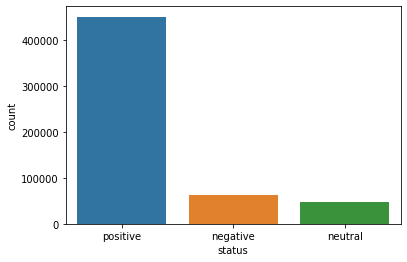

In [98]:
import seaborn as sns
sns.countplot(df_v1["status"])


In [99]:
import nltk 
from nltk import word_tokenize
nltk.download("punkt")

from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oztur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [100]:
df_v2 = df_v1.copy()

In [101]:
from unicodedata import normalize
df_v1.processed = df_v1.processed.str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')


In [104]:
import nltk
from nltk.corpus import stopwords,words
nltk.download('stopwords')
stop_words = stopwords.words("english")
stop_words = [word.replace("\'", "") for word in stop_words] # stop wordleri kaldırdım
df_v1["processed"] = df_v1["processed"].apply(lambda row: " ".join([token for token in row.split(" ") if token not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oztur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
df_v1["processed"].iloc[123131]

'lasted year docks would charge set phone certain way  devices house hold get lot use would work better charge  device dock per day'

In [106]:
import nltk
from nltk.stem import WordNetLemmatizer

df_v1["processed"] = df_v1["processed"].apply(lambda x : WordNetLemmatizer().lemmatize(x))

In [108]:
df_v1[["polarity" , "subjectivity"]] = df_v1["processed"].apply(lambda x : pd.Series(TextBlob(x).sentiment))

In [109]:
 df_v1.sample(5)

,reviewText,overall,unixReviewTime,processed,status,polarity,subjectivity
1644121,"I really like this motherboard, I have only ha...",5,02-21-2014,really like motherboard two months great far s...,positive,0.158542,0.491458
754030,I've owned 4 different helmet cams. After losi...,5,08-19-2011,ive owned different helmet cams losing tachyo...,positive,0.577778,0.733333
330798,I prefer the Cowon D2 for ogg playback support...,2,03-15-2008,prefer cowon ogg playback support though dis...,negative,0.300000,0.000000
104043,Not sure if all diversity antenna connections ...,4,01-07-2014,sure diversity antenna connections id say inst...,positive,0.261905,0.808201
347537,"This is the only TV box that I have, meaning I...",5,04-26-2009,tv box meaning could compare products really e...,positive,0.394444,0.640028


In [110]:
df_v1["processed"].iloc[122313]

'hung  tv bed room  heavy  seems sturdy even fully extended  nice small level'

In [111]:
df_v1.loc[df_v1["polarity"]>0.2 , "SentimentPolarity"] = "positive"
df_v1.loc[df_v1["polarity"]<-0.2 , "SentimentPolarity"] = "negative"
df_v1["SentimentPolarity"].fillna("neutral" , inplace=True)




<AxesSubplot:xlabel='SentimentPolarity', ylabel='count'>

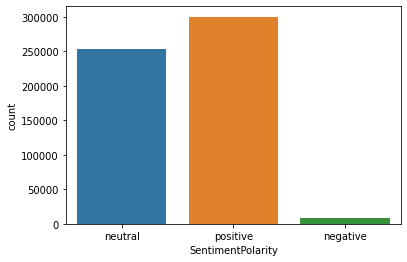

In [112]:
import seaborn as sns
sns.countplot(df_v1["SentimentPolarity"])

In [113]:
df_v1[["SentimentPolarity" , "status"]]

,SentimentPolarity,status
1186597,neutral,positive
611500,neutral,negative
634575,positive,positive
1627840,positive,positive
4589,positive,positive
...,...,...
531206,positive,positive
1212305,neutral,positive
1195731,positive,positive
1078785,neutral,negative


In [114]:
df_temp = df_v1.apply(lambda x: True if x["SentimentPolarity"]==x["status"]  else False, axis = 1)

<AxesSubplot:ylabel='count'>

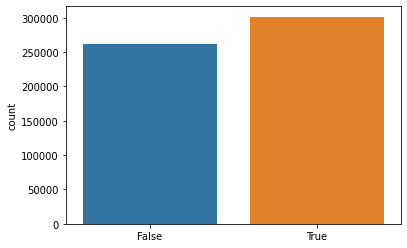

In [115]:
sns.countplot(df_temp)

# False değerler polarity ve status(yıldıza göre pozitif negatif olması) karşılaştırır
# Eğer ikisi de aynıysa True değerini gönderirir.
# Yani True değeri  kullanıcının yaptığı yorum ile verdiği yıldız sayısının paralel olduğunu gösterir

# Word Cloud

In [116]:
from PIL import Image

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                   mask =mask,
                   max_words=25000,
                   stopwords=stopwords)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Succesfully")
    path = "wc.png"
    display(Image.open(path))

Word Cloud Saved Succesfully


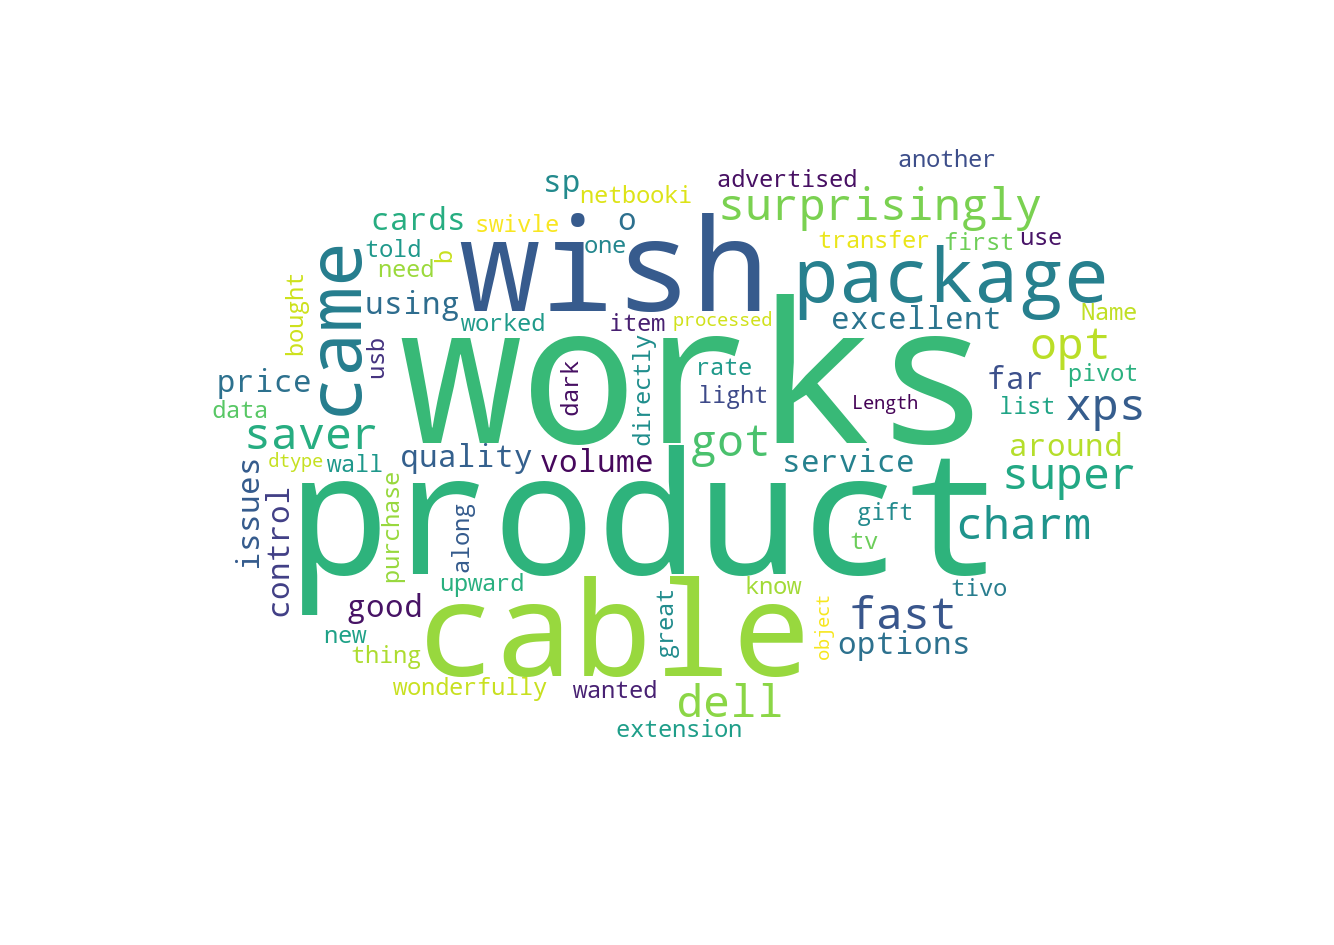

In [117]:
text1 = df_v1[df_v1["status"]=="positive"]
create_wordcloud(text1.processed)

Word Cloud Saved Succesfully


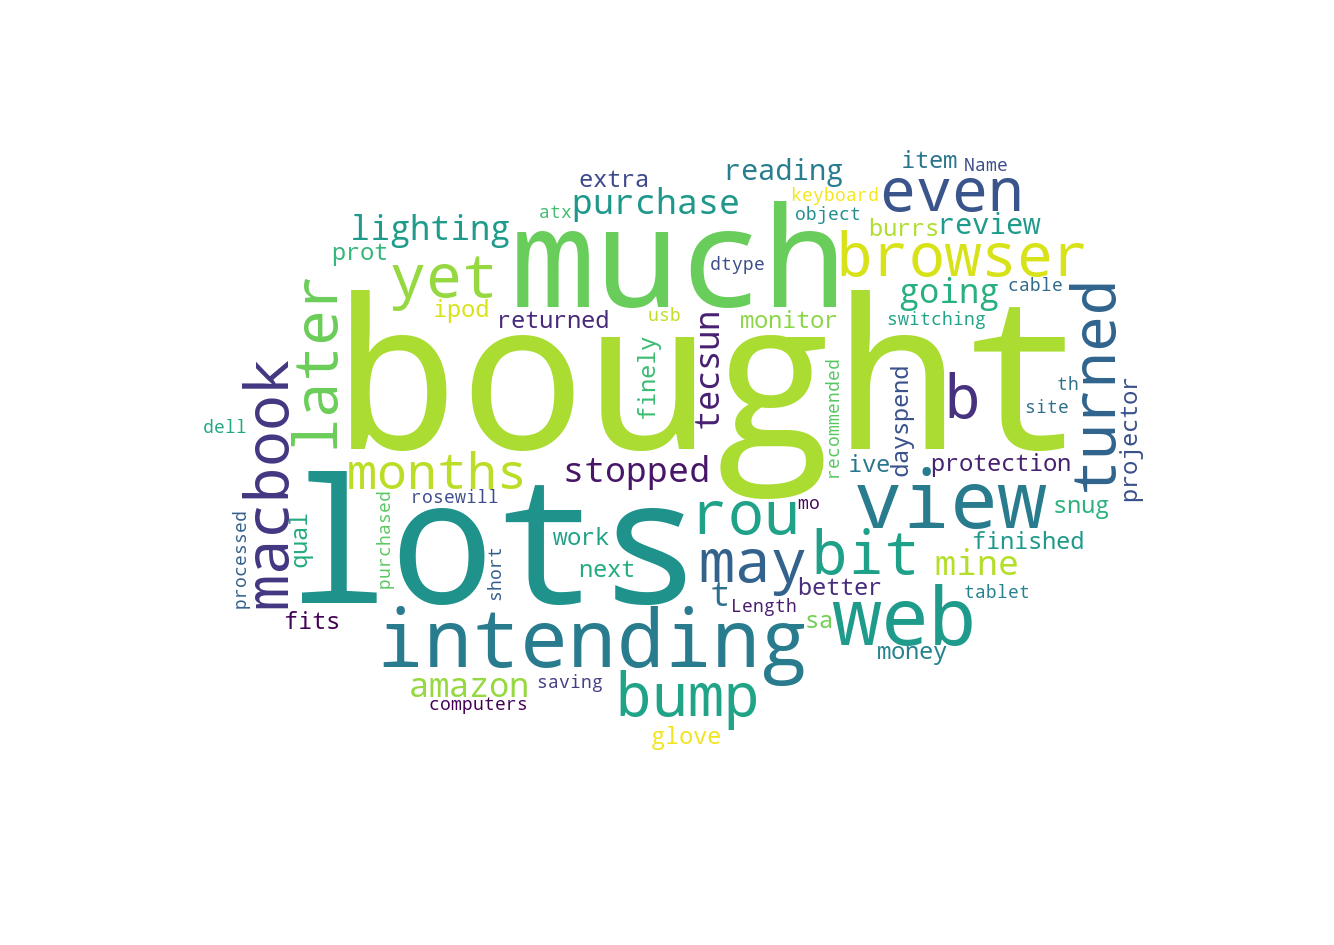

In [118]:
text2 = df_v1[df_v1["status"]=="negative"]
create_wordcloud(text2.processed)

Word Cloud Saved Succesfully


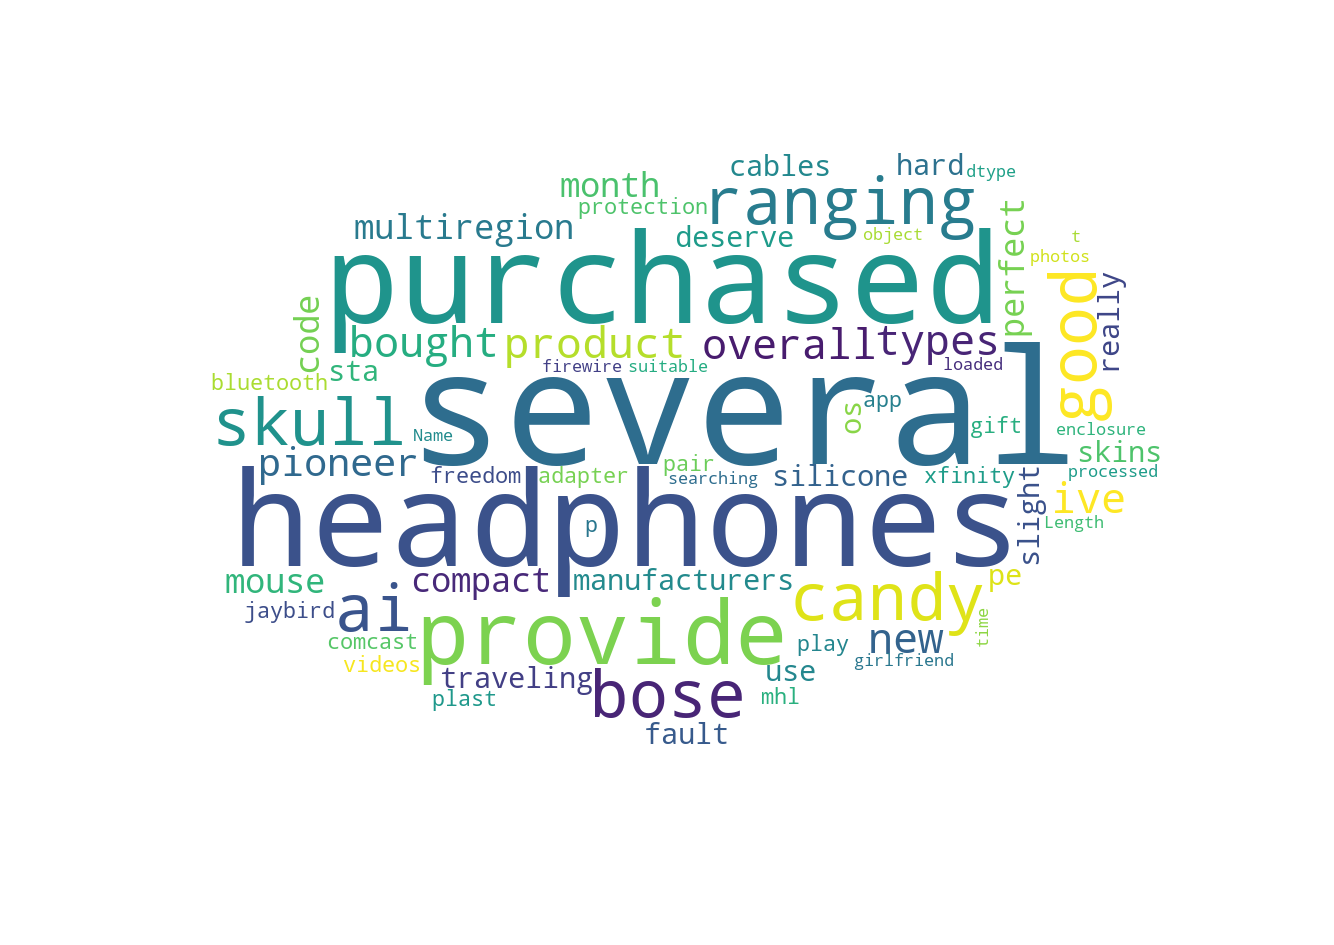

In [119]:
text3 = df_v1[df_v1["status"]=="neutral"]
create_wordcloud(text3.processed)

# Modelling

In [120]:
df_v1.to_csv('save.csv')

In [121]:
df_v1 = pd.read_csv("save.csv")

In [123]:

del df_v1["Unnamed: 0"]
df_v1.head()

,reviewText,overall,unixReviewTime,processed,status,polarity,subjectivity,SentimentPolarity
0,The package came surprisingly fast for super s...,4,04-19-2012,package came surprisingly fast super saver opt...,positive,0.111797,0.641126,neutral
1,I bought this intending to view it through a w...,2,03-28-2010,bought intending view web browser macbook rou...,negative,0.085606,0.452652,neutral
2,"I got it for my Dell XPS L502x, and it works l...",5,07-12-2012,got dell xps works like charm options around ...,positive,0.227778,0.477778,positive
3,"Good, quality product. I haven't had any issue...",5,04-28-2014,good quality product issues far using cards sp...,positive,0.366667,0.833333,positive
4,Excellent price and service. I like the volum...,5,05-27-2009,excellent price service like volume control o...,positive,0.708333,0.750000,positive


In [124]:
import sklearn 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.naive_bayes import MultinomialNB
m = MultinomialNB()

from sklearn.naive_bayes import BernoulliNB
b = BernoulliNB()

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [125]:
stemmer = SnowballStemmer("english")

def lemma(text):
  words = TextBlob(text).words
  return [stemmer.stem(word) for word in words]
# text leri vectorize ettik
vect = CountVectorizer( ngram_range=(1,2), analyzer=lemma)

In [132]:
df_v1.isnull().sum()
df_v1.dropna(inplace=True)

In [133]:
x = df_v1["processed"] # x ve y değerlerimi belirledim 
y = df_v1["SentimentPolarity"]

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

In [135]:
x_train_dtm = vect.fit_transform(x_train,y_train) 
x_test_dtm = vect.transform(x_test) 

In [136]:
model_m = m.fit(x_train_dtm,y_train)
predict_m = m.predict(x_test_dtm)
accuracy_score(y_test,predict_m)

0.734778745334992

In [137]:
model_b = b.fit(x_train_dtm,y_train)
predict_b = b.predict(x_test_dtm)
accuracy_score(y_test,predict_b)

0.6266642971387951

In [138]:
model_lr = lr.fit(x_train_dtm,y_train)
predict_lr = lr.predict(x_test_dtm)
accuracy_score(y_test,predict_lr)

0.9139150524258042

# Named Entity Recognition

In [157]:
import spacy
from collections import Counter

import en_core_web_sm

nlp = en_core_web_sm.load()

In [158]:
df_v1['processed'].apply(len).sum()

# Verimizin uzunluğu 1 milyondan fazla

221058883

In [159]:
df_ner = df_v1[df_v1["status"] == "negative"].sample(2000) 
df_ner['processed'].apply(len).sum()

873723

Negatif puan veren rastgele 2000 yorumu aldık

In [161]:
tokens = nlp(''.join(df_ner.processed.tolist()))

In [162]:
product_list = []  # ürün entity sine dahil olan kelimeleri tespit edip bir dataframe e ekliyoruz
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        product_list.append(ent.text)
        
product_counts = Counter(product_list).most_common(20)
df_product = pd.DataFrame(product_counts, columns =['text', 'count'])

In [163]:
df_product.head()

,text,count
0,dvd,16
1,canon,3
2,cup,2
3,kenneth cole,1
4,cole,1


In [164]:
org_list = [] # organizasyon, kurum entity sine dahil olan kelimeleri tespit edip bir dataframe e ekliyoruz
for ent in tokens.ents:
    if ent.label_ == 'ORG':
        org_list.append(ent.text)
        
org_counts = Counter(org_list).most_common(20)
df_org = pd.DataFrame(org_counts, columns =['text', 'count'])

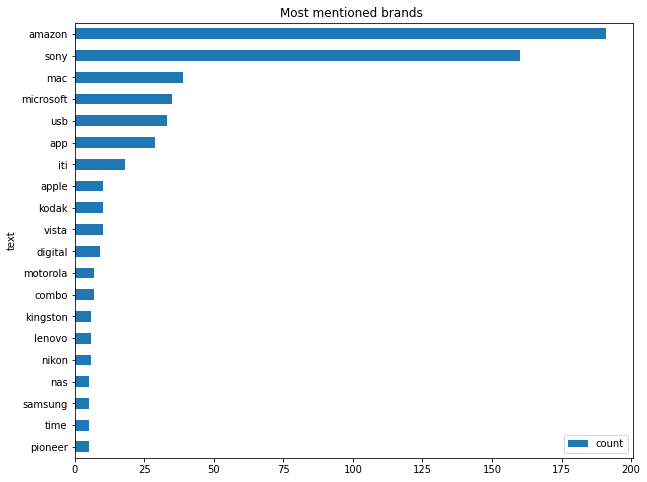

In [165]:
df_org.plot.barh(x='text', y='count', title="Most mentioned brands ", figsize=(10,8)).invert_yaxis()

Burada negatif yorumlarda en çok geçen şirketleri bulmuş olduk

Bu bilgi ile hangi şirketin en çok şikayet aldığını anlamış oluruz